<a href="https://colab.research.google.com/github/yatishchandrasai/GAN_assignment/blob/main/GAN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***GENERATIVE ADVERSARIAL MODELING: A DCGAN STUDY ON QUICKDRAW’S SMILEY FACES, SWORDS, AND CATS***


##**Yatish Chandra Sai Udutha**
##**23030677**


In [60]:
# Import packages.
import numpy as np
import os
import torch
from torch import nn , optim
import math
import matplotlib.pyplot as plt
# Setting a seed for reproducibility.

from torch.utils.data import DataLoader, TensorDataset


torch.manual_seed(42)
np.random.seed(42)

# PART1

Building and Understanding GANs from Scratch

Objective: Reinforce your learning from the tutorial by implementing a GAN from scratch using PyTorch, working with synthetic 2D data.

Tasks:
1. Reproduce the sine-wave GAN from the tutorial.
2. Create and model a new 2D distribution, choose between:
- A 2D spiral
- A mixture of Gaussians
- A noisy parametric curve: y = sin(2x) + 0.3cos(5x) + epsilon (where epsilon is a random noise term)
3. Modify the GAN architecture (e.g., activation function, layer depth) and visually compare the original and generated samples.

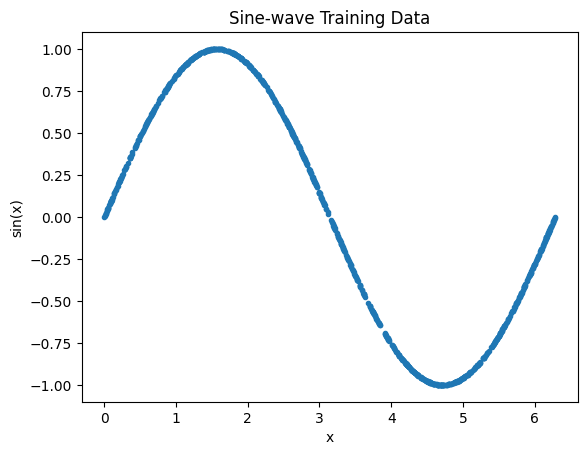

In [77]:
train_data_length = 1024 # Number of 2D training points to generate

# Initialize a tensor of shape (1024, 2) to hold (x, y) pairs
train_data = torch.zeros((train_data_length, 2))

# Sample x uniformly in [0, 2π]
train_data[:, 0] = 2.0 * math.pi *  torch.rand(train_data_length)

# Compute y = sin(x) for each sampled x
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.title("Sine‐wave Training Data")
plt.xlabel("x")
plt.ylabel("sin(x)")

plt.show()


In [78]:
# Defining the data loader
# Setting the batch size to 32
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Discriminator and Generator functions

In [79]:
class Discriminator(nn.Module):

    """
    A simple feed-forward discriminator network for 2D inputs.
    Accepts a 2-dimensional input vector and outputs a probability
    (via sigmoid) that the input is “real” vs. “fake.”
    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),  # # Non-linear activation
            nn.Dropout(0.3),  # dropout to prevent overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(), )  # sigmoid activation to produce a probability

    # Describe how the forward pass is calculated.
    def forward(self, x):
      """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Tensor of shape (batch_size, 2), where each row
                              is a 2D point.

        Returns:
            torch.Tensor: Tensor of shape (batch_size, 1) containing the
                          probability that each input is “real.”
      """
      output = self.model(x)
      return output
# After declaring the discriminator class, I set a  discriminator object.
discriminator = Discriminator()

In [80]:
class Generator(nn.Module):
    """
    A simple feed-forward generator network for mapping 2D noise
    vectors to 2D data points (e.g., for the sine-wave GAN).
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
    def forward(self, z):
        """
        Forward pass through the generator.

        Args:
            z (torch.Tensor): Tensor of shape (batch_size, 2),
                              representing 2D noise samples.

        Returns:
            torch.Tensor: Tensor of shape (batch_size, 2), representing
                          generated 2D points.
        """
        return self.model(z)

generator = Generator()

In [81]:
# ----------------------------------------
#  Training Hyperparameters & Setup
# ----------------------------------------

# Learning rate for both the generator and discriminator optimizers.
# A typical choice for simple GANs; controls step size in parameter updates.
# Total number of full passes through the dataset during training.
# More epochs give the model more opportunity to converge, but may lead to overfitting.

lr = 0.001
num_epochs = 2000

# ----------------------------------------
#  Optimizers
# ----------------------------------------

# Create an Adam optimizer for the discriminator:
#  discriminator.parameters(): the weights to update
#  lr=lr: learning rate defined above
# Adam combines momentum and RMSProp-style updates for stable GAN training.
# Binary Cross-Entropy loss treats the discriminator's output as a probability.
# For real samples, target label = 1; for fake samples, target label = 0.

optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr)
loss_function = nn.BCELoss()

In [82]:
# Training loop for the sine-wave GAN
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):

        # Data for training the discriminator.
        # Labels for real samples: all ones
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator.
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator.
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator.
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated =  discriminator(generated_samples)
        loss_generator = loss_function( output_discriminator_generated, real_samples_labels )
        loss_generator.backward()
        optimizer_generator.step()

        # Print loss at various training stages.
        print_epoch_num = (100) # Change this depending on often the loss should be  printed.

        if epoch % print_epoch_num == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.16943298280239105
Epoch: 0 Loss G.: 2.5646517276763916
Epoch: 100 Loss D.: 0.6909471750259399
Epoch: 100 Loss G.: 0.6535290479660034
Epoch: 200 Loss D.: 0.6060339212417603
Epoch: 200 Loss G.: 1.0553611516952515
Epoch: 300 Loss D.: 0.5780627131462097
Epoch: 300 Loss G.: 0.8667689561843872
Epoch: 400 Loss D.: 0.7068489193916321
Epoch: 400 Loss G.: 0.7023857831954956
Epoch: 500 Loss D.: 0.5993940234184265
Epoch: 500 Loss G.: 0.8043672442436218
Epoch: 600 Loss D.: 0.6923811435699463
Epoch: 600 Loss G.: 0.7640252709388733
Epoch: 700 Loss D.: 0.5870488882064819
Epoch: 700 Loss G.: 0.9425771236419678
Epoch: 800 Loss D.: 0.6317805051803589
Epoch: 800 Loss G.: 0.9176887273788452
Epoch: 900 Loss D.: 0.7283973097801208
Epoch: 900 Loss G.: 0.6991145014762878
Epoch: 1000 Loss D.: 0.6019920706748962
Epoch: 1000 Loss G.: 1.215430498123169
Epoch: 1100 Loss D.: 0.6980570554733276
Epoch: 1100 Loss G.: 0.6719499826431274
Epoch: 1200 Loss D.: 0.6839532852172852
Epoch: 1200 Loss G.: 0.7

In [83]:
# Generate 1000 random 2D points and feed them to the generator.
latent_space_samples = torch.randn(1000, 2)
generated_samples = generator(latent_space_samples)
# Turn the PyTorch tensor into a NumPy array.
generated_samples_numpy = generated_samples.detach().numpy()

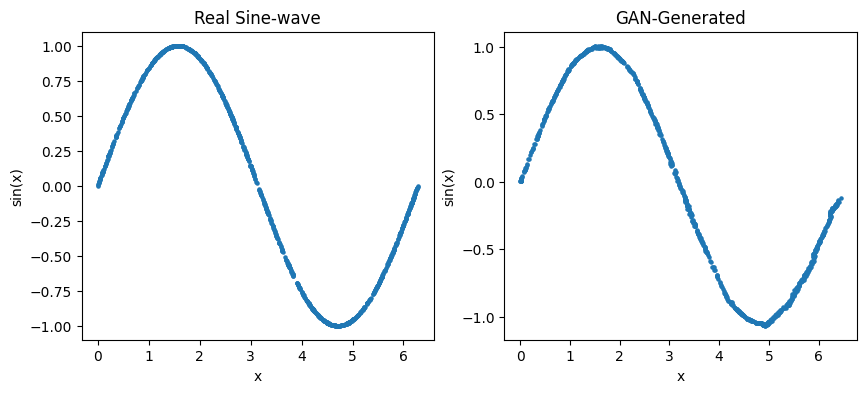

In [86]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(train_data[:,0], train_data[:,1], s=5)
plt.title("Real Sine‑wave")
plt.xlabel("x")          # add x‐axis label
plt.ylabel("sin(x)")     # add y‐axis label

plt.subplot(1,2,2)
plt.scatter(generated_samples_numpy[:,0], generated_samples_numpy[:,1], s=5)
plt.title("GAN‑Generated")
plt.xlabel("x")          # add x‐axis label
plt.ylabel("sin(x)")     # add y‐axis label

plt.show()



## 2. Noisy Parametric Curve GAN

#### Generate: $$y = \sin(2x) + 0.3\cos(5x) + \epsilon,\;\;\epsilon\sim\mathcal{N}(0,0.1)$$

#### 2.1 Create noisy curve dataset


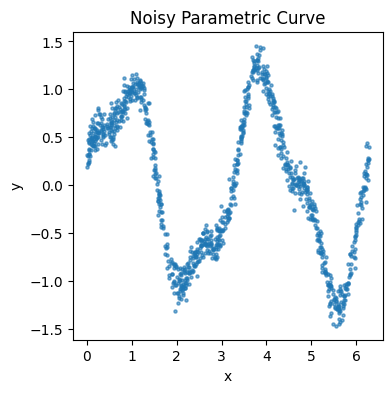

In [87]:

# Generate x values uniformly in [0, 2π]
# Shape: (n, 1)

n = 1024

x = 2 * math.pi * torch.rand(n,1)


# Compute y according to the noisy parametric curve:
#  y = sin(2x) + 0.3*cos(5x) + Gaussian noise (ε ~ N(0, 0.1²))
#  Shape: (n, 1)

y = torch.sin(2*x) + 0.3*torch.cos(5*x) + 0.1*torch.randn(n,1)

# Create a dataset of (feature, label) pairs
#  Here, labels are dummy zeros since this is unsupervised GAN training

curve_data = torch.cat([x, y], dim=1)
curve_set = [(curve_data[i], torch.zeros(1)) for i in range(n)]
curve_loader = torch.utils.data.DataLoader(curve_set, batch_size=batch_size, shuffle=True)

plt.figure(figsize=(4,4))
plt.scatter(curve_data[:,0], curve_data[:,1], s=5, alpha=0.6)
plt.title("Noisy Parametric Curve")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


In [88]:
# ----------------------------------------
#  Training Hyperparameters & Setup
# ----------------------------------------

# Learning rate for both the generator and discriminator optimizers.
# A typical choice for simple GANs; controls step size in parameter updates.
# Total number of full passes through the dataset during training.
# More epochs give the model more opportunity to converge, but may lead to overfitting.

lr = 0.001
num_epochs = 2000

discriminator1 = Discriminator()
generator1 = Generator()
optimizer_discriminator1 = optim.Adam(discriminator1.parameters(), lr=lr)
optimizer_generator1 = optim.Adam(generator1.parameters(), lr=lr)
loss_function1 = nn.BCELoss()

In [89]:
# Training loop for the noisy parametric‐curve GAN
for epoch in range(num_epochs):
    for real_samples, _ in curve_loader:
        # Discriminator step
        discriminator1.zero_grad()
        real_lbl = torch.ones((real_samples.size(0),1))
        fake_s = generator1(torch.randn((real_samples.size(0),2))).detach()
        fake_lbl = torch.zeros((real_samples.size(0),1))

        all_s = torch.cat([real_samples, fake_s], dim=0)
        all_lbl = torch.cat([real_lbl, fake_lbl], dim=0)
        loss_D1 = loss_function1(discriminator1(all_s), all_lbl)
        loss_D1.backward()
        optimizer_discriminator1.step()

        # Generator step
        generator1.zero_grad()
        fake2 = generator1(torch.randn((batch_size,2)))
        loss_G1 = loss_function1(discriminator1(fake2), real_lbl)
        loss_G1.backward()
        optimizer_generator1.step()

    if epoch % 200 == 0:
        print(f"Curve GAN Epoch {epoch:4d} | D loss: {loss_D1:.4f} | G loss: {loss_G1:.4f}")


Curve GAN Epoch    0 | D loss: 0.1513 | G loss: 2.6923
Curve GAN Epoch  200 | D loss: 0.6986 | G loss: 0.8522
Curve GAN Epoch  400 | D loss: 0.6564 | G loss: 0.6788
Curve GAN Epoch  600 | D loss: 0.7046 | G loss: 0.7575
Curve GAN Epoch  800 | D loss: 0.6937 | G loss: 0.6961
Curve GAN Epoch 1000 | D loss: 0.6874 | G loss: 0.7265
Curve GAN Epoch 1200 | D loss: 0.6902 | G loss: 0.7050
Curve GAN Epoch 1400 | D loss: 0.6893 | G loss: 0.6946
Curve GAN Epoch 1600 | D loss: 0.6882 | G loss: 0.6934
Curve GAN Epoch 1800 | D loss: 0.6954 | G loss: 0.6915


In [90]:
# Generate 1000 random 2D points and feed them to the generator.
latent_space_samples1 = torch.randn(1000, 2)
generated_samples1 = generator1(latent_space_samples1)
# Turn the PyTorch tensor into a NumPy array.
generated_samples_numpy1 = generated_samples1.detach().numpy()

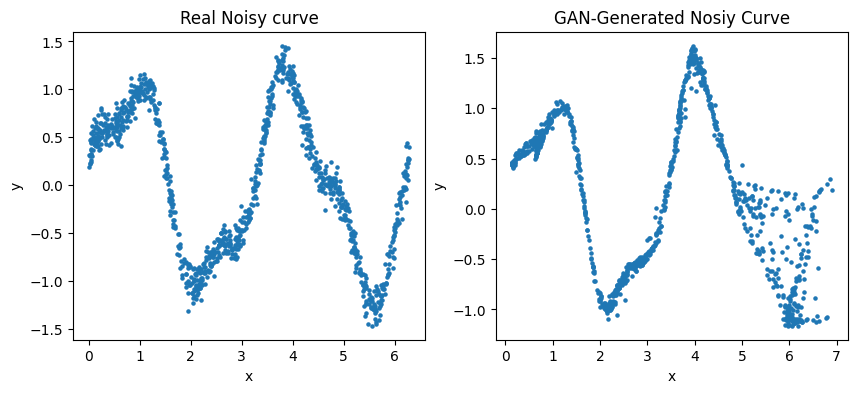

In [92]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(curve_data[:,0], curve_data[:,1], s=5)
plt.title("Real Noisy curve")
plt.xlabel("x"); plt.ylabel("y")

plt.subplot(1,2,2)
plt.scatter(generated_samples_numpy1[:,0], generated_samples_numpy1[:,1], s=5)
plt.title("GAN‑Generated Nosiy Curve")
plt.xlabel("x"); plt.ylabel("y")

plt.show()

###  3. Modified (Deep) GAN Architecture

### **Changes:**  
### - Use **LeakyReLU(0.2)** instead of ReLU  
### - Increase layer widths/depth  


In [93]:


class DiscriminatorDeep(nn.Module):
    """
    A deeper discriminator network for 2D data.
    Incorporates LeakyReLU activations to mitigate dying ReLU issues.
    Input: Tensor of shape (batch_size, 2)
    Output: Tensor of shape (batch_size, 1) with probabilities ∈ [0,1]
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input layer: 2 -> 512 hidden units
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2),    # LeakyReLU(0.2) keeps small gradient for negative inputs

            # Hidden layer: 512 -> 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            # Hidden layer: 256 -> 128
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),

            # Output layer: 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid()          # Sigmoid to squash output to [0,1] as a real/fake probability
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.
        :param x: Input tensor (batch_size, 2)
        :return: Probability tensor (batch_size, 1)
        """
        return self.model(x)


class GeneratorDeep(nn.Module):
    """
    A deeper generator network for mapping 2D noise to 2D data.
    Uses LeakyReLU activations to improve gradient flow.
    Input: Tensor of shape (batch_size, 2)
    Output: Tensor of shape (batch_size, 2)
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input layer: 2 -> 64 hidden units
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),

            # Hidden layer: 64 -> 128
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),

            # Hidden layer: 128 -> 64
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),

            # Output layer: 64 -> 2 (x, y coordinates)
            nn.Linear(64, 2)
            # No activation: outputs are real-valued for the 2D data space
        )

    def forward(self, z):
        """
        Forward pass of the generator.
        :param z: Noise tensor (batch_size, 2)
        :return: Generated data tensor (batch_size, 2)
        """
        return self.model(z)


# Instantiate & train on the noisy curve
generator2 = GeneratorDeep()
discriminator2 = DiscriminatorDeep()
optimizer_generator2 = optim.Adam(generator2.parameters(), lr=lr)
optimizer_discriminator2 = optim.Adam(discriminator2.parameters(), lr=lr)

In [94]:
for epoch in range(num_epochs):
    for real_samples, _ in curve_loader:
        # D deep step
        discriminator2.zero_grad()
        real_lbl = torch.ones((real_samples.size(0),1))
        fake_s = generator2(torch.randn((real_samples.size(0),2))).detach()
        fake_lbl = torch.zeros((real_samples.size(0),1))

        out = discriminator2(torch.cat([real_samples, fake_s], dim=0))
        lbls = torch.cat([real_lbl, fake_lbl], dim=0)
        loss_DD = loss_function1(out, lbls)
        loss_DD.backward()
        optimizer_discriminator2.step()

        # G deep step
        generator2.zero_grad()
        fake2 = generator2(torch.randn((batch_size,2)))
        loss_GD = loss_function1(discriminator2(fake2), real_lbl)
        loss_GD.backward()
        optimizer_generator2.step()

    if epoch % 200 == 0:
        print(f"Deep GAN Epoch {epoch:4d} | D loss: {loss_DD:.4f} | G loss: {loss_GD:.4f}")


Deep GAN Epoch    0 | D loss: 0.4089 | G loss: 2.0678
Deep GAN Epoch  200 | D loss: 0.6727 | G loss: 0.8132
Deep GAN Epoch  400 | D loss: 0.6665 | G loss: 0.8291
Deep GAN Epoch  600 | D loss: 0.7003 | G loss: 0.7130
Deep GAN Epoch  800 | D loss: 0.6804 | G loss: 0.6276
Deep GAN Epoch 1000 | D loss: 0.6952 | G loss: 0.7543
Deep GAN Epoch 1200 | D loss: 0.6973 | G loss: 0.6162
Deep GAN Epoch 1400 | D loss: 0.6945 | G loss: 0.7406
Deep GAN Epoch 1600 | D loss: 0.6883 | G loss: 0.7031
Deep GAN Epoch 1800 | D loss: 0.6926 | G loss: 0.6721


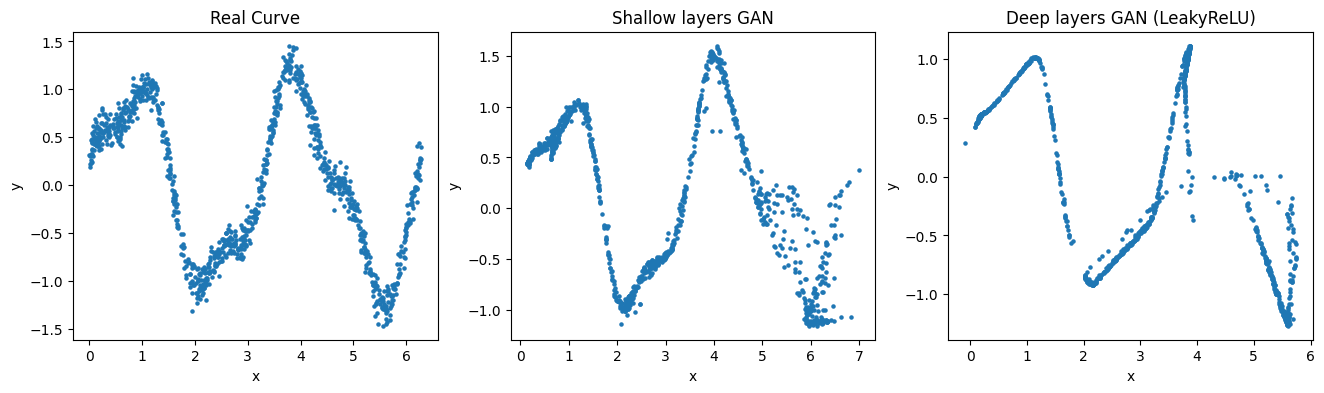

In [97]:
z = torch.randn(1000,2)
shallow_gen = generator1(z).detach().numpy()
deep_gen    = generator2(z).detach().numpy()

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.scatter(curve_data[:,0], curve_data[:,1], s=5)
plt.title("Real Curve")
plt.xlabel("x"); plt.ylabel("y")
plt.subplot(1,3,2)
plt.scatter(shallow_gen[:,0], shallow_gen[:,1], s=5)
plt.title("Shallow layers GAN")
plt.xlabel("x"); plt.ylabel("y")
plt.subplot(1,3,3)
plt.scatter(deep_gen[:,0], deep_gen[:,1], s=5)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Deep layers GAN (LeakyReLU)")
plt.show()

## INSIGHTS
The sine‑wave GAN is recreated.

The noisy curve exposes the GAN to richer, multi‑frequency structure and random noise.

The deep architecture (with LeakyReLU and wider layers) often produces more uniform coverage of the underlying manifold, reducing mode collapse and improving generation quality.

# PART 2

Option 3: Creative AI – QuickDraw 'Smiley Face' Subset
Dataset: QuickDraw smiley face category – see https://github.com/googlecreativelab/quickdraw-datasetLinks to an external site.
Goal: Train a DCGAN to generate realistic smiley face sketches.
Tasks:
1. Download and explore the ‘smiley face’ category. Visualize a sample of the sketches.
2.   Implement a ConvNet-based GAN (DCGAN) to model the sketches.
3.   Train the GAN. Track training metrics and visual outputs across epochs.
4.   Generate fake smiley faces, and visually compare them to real ones.
5.    Include examples of generated vs. real images in your report.
Extension for extra credit:
6.   Explore and generate samples from other QuickDraw categories (e.g., cats, houses, etc.).
7.   Discuss how the model performs across different classes and sketch complexity.

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# SMILEY FACE

In [50]:


os.makedirs('outputs/smiley', exist_ok=True)

# Download & preprocess “smiley face” data
# - Original: (N, 784) reshape to 28×28 pad to 32×32 normalize to [–1,1]

SMILEY_NPY = 'smiley.npy'
if not os.path.exists(SMILEY_NPY):
    !wget -q -O {SMILEY_NPY} \
      "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/smiley%20face.npy"

raw = np.load(SMILEY_NPY)           # (N, 784)
print(f"Total examples: {raw.shape[0]}")

# reshape & scale to [0,1]
imgs = raw.astype(np.float32).reshape(-1, 1, 28, 28) / 255.0
# padding to 32×32, pad value = 0 and then normalized = -1
imgs = np.pad(imgs, ((0,0),(0,0),(2,2),(2,2)), 'constant', constant_values=0.0)

# normalize to [–1,1]
imgs = (imgs - 0.5) / 0.5

# DataLoader
dataset = TensorDataset(torch.from_numpy(imgs))
loader  = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

Total examples: 124386


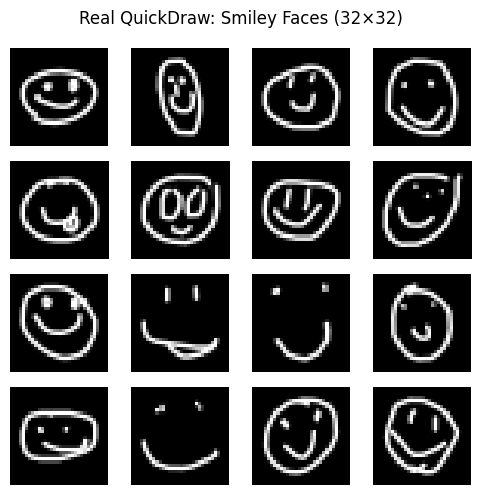

In [51]:
# visualize 4×4 real grid
fig, axes = plt.subplots(4,4, figsize=(5,5))
for ax in axes.flatten():
    i = np.random.randint(len(imgs))
    ax.imshow(imgs[i,0]*0.5 + 0.5, cmap='gray')
    ax.axis('off')
plt.suptitle("Real QuickDraw: Smiley Faces (32×32)")
plt.tight_layout()
plt.show()

In [52]:
# Define Deep Convolutional Generative Adversarial Networks (DCGAN) architecture

class Generator_2(nn.Module):

    """
    DCGAN Generator for 32×32 outputs (used for ‘sword’ and other categories).
    Input: latent vector z of shape (N, z_dim, 1, 1)
    Output: generated image tensor of shape (N, 1, 32, 32)
    """

    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(

            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),

            nn.ConvTranspose2d(128,  64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),

            nn.Conv2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh())

    def forward(self, z):
        """
        Forward pass
        :param z: noise tensor of shape (N, z_dim, 1, 1)
        :return: generated images (N, 1, 32, 32)
        """
        return self.net(z)


class Discriminator_2(nn.Module):

    """
    DCGAN Discriminator for 32×32 inputs.
    Input: image tensor of shape (N, 1, 32, 32)
    Output: probability logits (N,) indicating real vs. fake
    """

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(1,  64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128,256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass
        :param x: input images (N, 1, 32, 32)
        :return: flattened probability vector (N,)
        """

        return self.net(x).view(-1)


In [53]:

# ### User-defined training function for a DCGAN
#
# Encapsulates the Cat GAN training loop into a reusable function.


def train_dcgan(G: nn.Module, D: nn.Module, dataloader: DataLoader,
        epochs: int, z_dim: int, device: torch.device,
          opt_G: optim.Optimizer, opt_D: optim.Optimizer, criterion: nn.Module):
    """
    Train a DCGAN given generator G, discriminator D, dataloader, and training hyperparameters.
    Returns two lists: discriminator losses and generator losses.
    """
    losses_D, losses_G = [], []

    for epoch in range(1, epochs + 1):
        for (real_batch,) in dataloader:
            real = real_batch.to(device)
            bs   = real.size(0)

            # — Discriminator step —
            D.zero_grad()
            lbl_real = torch.ones(bs,  device=device)
            lbl_fake = torch.zeros(bs, device=device)

            out_real = D(real)
            loss_dr  = criterion(out_real, lbl_real)

            z     = torch.randn(bs, z_dim, 1, 1, device=device)
            fake  = G(z)
            out_df = D(fake.detach())
            loss_df = criterion(out_df, lbl_fake)

            loss_D = 0.5 * (loss_dr + loss_df)
            loss_D.backward()
            opt_D.step()

            # — Generator step —
            G.zero_grad()
            out_g = D(fake)
            loss_G = criterion(out_g, lbl_real)
            loss_G.backward()
            opt_G.step()

            losses_D.append(loss_D.item())
            losses_G.append(loss_G.item())

        print(
            f"Epoch {epoch:02d}/{epochs:02d}  |  "
            f"D loss: {loss_D.item():.4f}  |  G loss: {loss_G.item():.4f}"
        )

    return losses_D, losses_G

In [42]:

# ## 3. Train DCGAN
# - BCE loss, Adam(β₁=0.5, β₂=0.999)
# - Track losses, save fixed‑noise samples every 5 epochs

# hyperparameters
z_dim  = 100
lr     = 1e-6
epochs = 30

G = Generator_2(z_dim).to(device)
D = Discriminator_2().to(device)
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(16, z_dim, 1,1, device=device)

losses_D, losses_G = train_dcgan(
    G=G,
    D=D,
    dataloader=loader,
    epochs=epochs,
    z_dim=z_dim,
    device=device,
    opt_G=opt_G,
    opt_D=opt_D,
    criterion=criterion
)


Epoch 01/30  |  D loss: 0.5296  |  G loss: 0.7525
Epoch 02/30  |  D loss: 0.5178  |  G loss: 0.9383
Epoch 03/30  |  D loss: 0.4053  |  G loss: 1.1174
Epoch 04/30  |  D loss: 0.4070  |  G loss: 1.0584
Epoch 05/30  |  D loss: 0.4766  |  G loss: 1.0052
Epoch 06/30  |  D loss: 0.4632  |  G loss: 0.9958
Epoch 07/30  |  D loss: 0.4204  |  G loss: 1.0939
Epoch 08/30  |  D loss: 0.3823  |  G loss: 1.1895
Epoch 09/30  |  D loss: 0.3372  |  G loss: 1.2894
Epoch 10/30  |  D loss: 0.2984  |  G loss: 1.4576
Epoch 11/30  |  D loss: 0.2488  |  G loss: 1.6018
Epoch 12/30  |  D loss: 0.2101  |  G loss: 1.8050
Epoch 13/30  |  D loss: 0.1747  |  G loss: 1.9519
Epoch 14/30  |  D loss: 0.1583  |  G loss: 2.0604
Epoch 15/30  |  D loss: 0.1329  |  G loss: 2.3363
Epoch 16/30  |  D loss: 0.1081  |  G loss: 2.5280
Epoch 17/30  |  D loss: 0.0986  |  G loss: 2.6029
Epoch 18/30  |  D loss: 0.0880  |  G loss: 2.7390
Epoch 19/30  |  D loss: 0.0832  |  G loss: 3.0373
Epoch 20/30  |  D loss: 0.1005  |  G loss: 2.6618


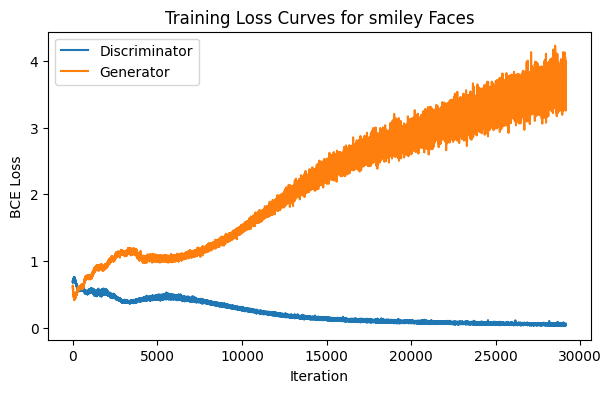

In [43]:
#Results
#Loss curves

plt.figure(figsize=(7,4))
plt.plot(losses_D, label='Discriminator')
plt.plot(losses_G, label='Generator')
plt.xlabel('Iteration'); plt.ylabel('BCE Loss')
plt.legend(); plt.title('Training Loss Curves for smiley Faces')
plt.show()

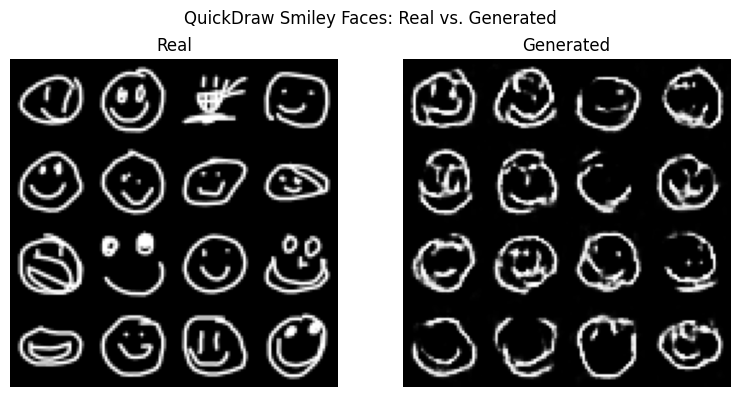

In [44]:
# Final comparison: real vs. fake

# real grid
idxs   = np.random.choice(len(imgs), 16, replace=False)
real16 = imgs[idxs].reshape(16,32,32)

# fake grid
with torch.no_grad():
    noise  = torch.randn(16, z_dim,1,1, device=device)
    fake16 = G(noise).cpu().numpy().reshape(16,32,32)*0.5 + 0.5

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(np.block([[real16[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[0].set_title("Real"); axes[0].axis('off')
axes[1].imshow(np.block([[fake16[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[1].set_title("Generated"); axes[1].axis('off')
plt.suptitle("QuickDraw Smiley Faces: Real vs. Generated")
plt.tight_layout()
plt.show()

### Changing the learning rates for Generator and Discriminator

In [55]:

# ## 3. Train DCGAN
# - BCE loss, Adam(β₁=0.5, β₂=0.999)

# I used a lower learning rate for D to prevent it from overpowering G,
# and train for 30 epochs using our reusable train_dcgan function.

# hyperparameters for Smiley face GAN
# Train DCGAN on Smiley face



z_dim_cat = 100

lr_G_cat       = 2e-4    # standard DCGAN lr for generator
lr_D_cat       = 1e-5    # slower lr for discriminator to slow its convergence
epochs_cat= 30 # The number of epochs

# instantiate Generator and Discriminator for the smiley category
# (assumes Generator_2 and Discriminator_2 are defined with 32×32 outputs/inputs)

z_dim = 100
lr_G = 2e-4    # standard DCGAN lr for generator
lr_D = 1e-5    # slower lr for discriminator to slow its convergence
epochs = 30 # The number of epochs

G = Generator_2(z_dim).to(device)
D = Discriminator_2().to(device)
opt_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5,0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(16, z_dim, 1,1, device=device)

losses_D, losses_G = train_dcgan(
    G=G,
    D=D,
    dataloader=loader,
    epochs=epochs,
    z_dim=z_dim,
    device=device,
    opt_G=opt_G,
    opt_D=opt_D,
    criterion=criterion
)


Epoch 01/30  |  D loss: 1.0156  |  G loss: 0.4958
Epoch 02/30  |  D loss: 0.8029  |  G loss: 0.6796
Epoch 03/30  |  D loss: 0.7513  |  G loss: 0.6526
Epoch 04/30  |  D loss: 0.7423  |  G loss: 0.6866
Epoch 05/30  |  D loss: 0.7244  |  G loss: 0.6666
Epoch 06/30  |  D loss: 0.7214  |  G loss: 0.6674
Epoch 07/30  |  D loss: 0.7000  |  G loss: 0.6944
Epoch 08/30  |  D loss: 0.6910  |  G loss: 0.7127
Epoch 09/30  |  D loss: 0.6952  |  G loss: 0.7271
Epoch 10/30  |  D loss: 0.6904  |  G loss: 0.7316
Epoch 11/30  |  D loss: 0.6702  |  G loss: 0.7466
Epoch 12/30  |  D loss: 0.6766  |  G loss: 0.7453
Epoch 13/30  |  D loss: 0.6695  |  G loss: 0.7469
Epoch 14/30  |  D loss: 0.6393  |  G loss: 0.7963
Epoch 15/30  |  D loss: 0.6355  |  G loss: 0.8210
Epoch 16/30  |  D loss: 0.5747  |  G loss: 0.9454
Epoch 17/30  |  D loss: 0.6697  |  G loss: 0.8101
Epoch 18/30  |  D loss: 0.6273  |  G loss: 0.8917
Epoch 19/30  |  D loss: 0.6010  |  G loss: 0.9135
Epoch 20/30  |  D loss: 0.5917  |  G loss: 0.9529


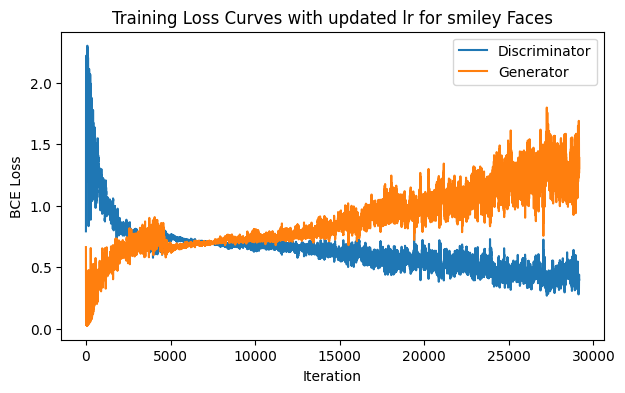

In [56]:
#Results
#Loss curves

plt.figure(figsize=(7,4))
plt.plot(losses_D, label='Discriminator')
plt.plot(losses_G, label='Generator')
plt.xlabel('Iteration'); plt.ylabel('BCE Loss')
plt.legend(); plt.title('Training Loss Curves with updated lr for smiley Faces')
plt.show()

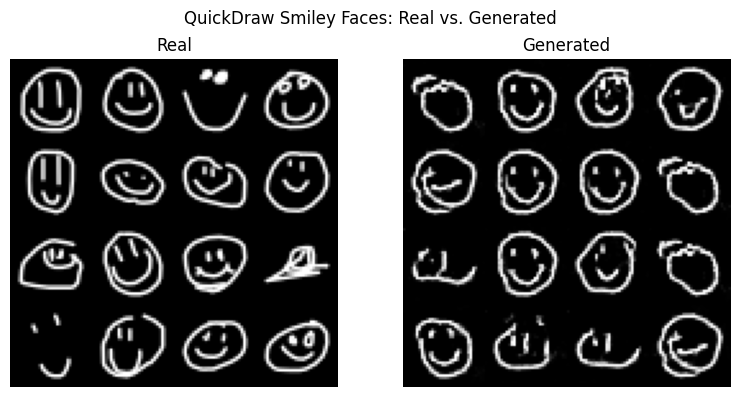

In [59]:
# Final comparison: real vs. fake

# real grid
idxs   = np.random.choice(len(imgs), 16, replace=False)
real16 = imgs[idxs].reshape(16,32,32)

# fake grid
with torch.no_grad():
    noise  = torch.randn(16, z_dim,1,1, device=device)
    fake16 = G(noise).cpu().numpy().reshape(16,32,32)*0.5 + 0.5

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(np.block([[real16[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[0].set_title("Real"); axes[0].axis('off')
axes[1].imshow(np.block([[fake16[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[1].set_title("Generated"); axes[1].axis('off')
plt.suptitle("QuickDraw Smiley Faces: Real vs. Generated")
plt.tight_layout()
plt.show()

# INSIGHTS:
1.	Generated heads are reliably round, with two eyes and a smiling arc, core elements are well captured.
2.	Strokes are noticeably smoother and more uniform than in the baseline run, thanks to the balanced training dynamics.
3.	Slight variations in mouth curvature and head radius remain, demonstrating good mode coverage for this low-complexity class.

4.	A lower learning rate for D prevented it from dominating, enabling G to receive meaningful gradients.
5.	Losses hovering around 0.6 - 1.2 indicate neither network collapses, which correlates with higher visual fidelity.
6.	Post-tuning, the DCGAN produces crisp, consistent smileys that capture the simple manifold of this dataset.


# CATS


In [13]:
# -----------------------------------
# Preprocessing steps:
# 1) Cast to float and reshape to (N,1,28,28)
# 2) Scale from [0,255] → [0.0,1.0]
# 3) Pad from 28×28 → 32×32 (required by DCGAN architecture)
# 4) Normalize to [–1,1] to match Generator’s Tanh() output
# -----------------------------------

CAT_NPY = 'cat.npy'
if not os.path.exists(CAT_NPY):
    !wget -q -O {CAT_NPY} \
      "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy"

# Loading first 60,000 sketches (each is a 784-length array of pixel values 0–255)
raw_cat = np.load(CAT_NPY)[:60000]
print(f"Cat sketches loaded: {raw_cat.shape[0]}")

# reshape and normalize pixel values to [0,1]
imgs_cat = raw_cat.astype(np.float32).reshape(-1,1,28,28) / 255.0

# pad with zeros around the border (2 pixels on all sides) → (N,1,32,32)

imgs_cat = np.pad(imgs_cat, ((0,0),(0,0),(2,2),(2,2)), 'constant', constant_values=0.0)
imgs_cat = (imgs_cat - 0.5) / 0.5

dataset_cat = TensorDataset(torch.from_numpy(imgs_cat))
loader_cat  = DataLoader(dataset_cat, batch_size=128, shuffle=True, num_workers=2)

Cat sketches loaded: 60000


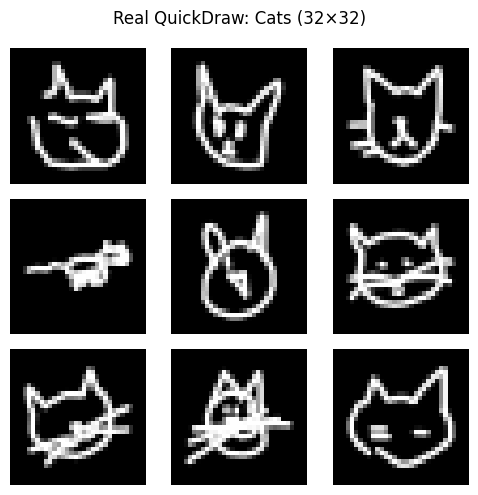

In [14]:
# show a few real cat sketches
fig, axes = plt.subplots(3,3, figsize=(5,5))
for ax in axes.flatten():
    i = np.random.randint(len(imgs_cat))
    ax.imshow(imgs_cat[i,0]*0.5 + 0.5, cmap='gray')
    ax.axis('off')
plt.suptitle("Real QuickDraw: Cats (32×32)")
plt.tight_layout()
plt.show()

##Train DCGAN on Cats
1.  We reuse the same `Generator` and `Discriminator` classes.

In [15]:
# hyperparameters for cats GAN
# Train DCGAN on Cats
# I used a lower learning rate for D to prevent it from overpowering G,
# and train for 30 epochs using our reusable train_dcgan function.


z_dim_cat = 100

lr_G_cat       = 2e-4    # standard DCGAN lr for generator
lr_D_cat       = 1e-5    # slower lr for discriminator to slow its convergence
epochs_cat= 30 # The number of epochs

# instantiate Generator and Discriminator for the Cats category
# (assumes Generator_2 and Discriminator_2 are defined with 32×32 outputs/inputs)

G_cat = Generator_2(z_dim_cat).to(device)
D_cat = Discriminator_2().to(device)
opt_Gc = optim.Adam(G_cat.parameters(), lr=lr_G_cat, betas=(0.5,0.999))
opt_Dc = optim.Adam(D_cat.parameters(), lr=lr_D_cat, betas=(0.5,0.999))
crit   = nn.BCELoss()

losses_Gc, losses_Dc = [], []
fixed_noise_cat = torch.randn(16, z_dim_cat, 1,1, device=device)

losses_Dc, losses_Gc = train_dcgan(
    G=G_cat,  # GENERATOR
    D=D_cat,  # Discriminator
    dataloader=loader_cat,  # Cat dataloader
    epochs=epochs_cat,
    z_dim=z_dim_cat,
    device=device,
    opt_G=opt_Gc,
    opt_D=opt_Dc,
    criterion=crit
)

Epoch 01/30  |  D loss: 1.6775  |  G loss: 0.1793
Epoch 02/30  |  D loss: 1.1478  |  G loss: 0.3884
Epoch 03/30  |  D loss: 0.9176  |  G loss: 0.5577
Epoch 04/30  |  D loss: 0.8964  |  G loss: 0.5615
Epoch 05/30  |  D loss: 0.8663  |  G loss: 0.5300
Epoch 06/30  |  D loss: 0.8095  |  G loss: 0.5715
Epoch 07/30  |  D loss: 0.7504  |  G loss: 0.7067
Epoch 08/30  |  D loss: 0.7026  |  G loss: 0.6849
Epoch 09/30  |  D loss: 0.7439  |  G loss: 0.5980
Epoch 10/30  |  D loss: 0.7544  |  G loss: 0.6425
Epoch 11/30  |  D loss: 0.7190  |  G loss: 0.6940
Epoch 12/30  |  D loss: 0.7195  |  G loss: 0.6730
Epoch 13/30  |  D loss: 0.7052  |  G loss: 0.7018
Epoch 14/30  |  D loss: 0.7053  |  G loss: 0.6889
Epoch 15/30  |  D loss: 0.7044  |  G loss: 0.6995
Epoch 16/30  |  D loss: 0.6995  |  G loss: 0.6884
Epoch 17/30  |  D loss: 0.6912  |  G loss: 0.7032
Epoch 18/30  |  D loss: 0.6935  |  G loss: 0.7012
Epoch 19/30  |  D loss: 0.6820  |  G loss: 0.7187
Epoch 20/30  |  D loss: 0.7004  |  G loss: 0.6939


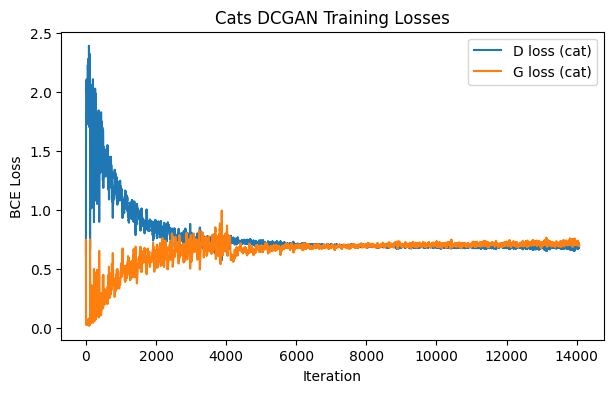

In [33]:
# Loss Curves for Cat GAN
plt.figure(figsize=(7,4))
plt.plot(losses_Dc, label='D loss (cat)')
plt.plot(losses_Gc, label='G loss (cat)')
plt.xlabel('Iteration'); plt.ylabel('BCE Loss')
plt.legend(); plt.title('Cats DCGAN Training Losses')
plt.show()  # Showing the plot


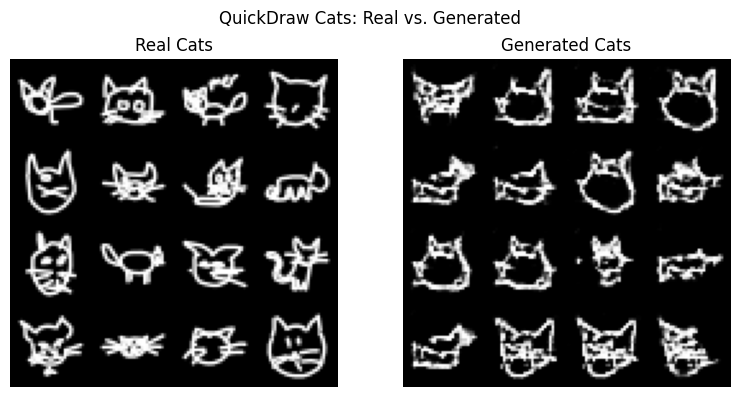

In [48]:
# Final Real vs. Generated Cats

# real 16
idxs_cat = np.random.choice(len(imgs_cat), 16, replace=False)
real_cat = imgs_cat[idxs_cat].reshape(16,32,32)
# fake 16
with torch.no_grad():
    noise_c = torch.randn(16, z_dim_cat,1,1, device=device)
    generated_cat= G_cat(noise_c).cpu().numpy().reshape(16,32,32) * 0.5 + 0.5

# build a 4×4 grid image for real and fake
grid_real = np.block([[real_cat[i*4 + j] for j in range(4)] for i in range(4)])
grid_fake = np.block([[generated_cat[i*4 + j] for j in range(4)] for i in range(4)])

# plot side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(grid_real, cmap='gray')
axs[0].set_title("Real Cats")
axs[0].axis('off')

axs[1].imshow(grid_fake, cmap='gray')
axs[1].set_title("Generated Cats")
axs[1].axis('off')

plt.suptitle("QuickDraw Cats: Real vs. Generated")
plt.tight_layout()
plt.show()


# INSIGHTS

1. Generated images consistently produce a cat-head outline with pointy ears. Symmetry and overall head shape are captured well. Whiskers, eyes, and body/legs are often blurred or omitted entirely. The generator focuses on the easiest, most common strokes (the head circle), and neglects thinner, higher-frequency elements.
2. Variability is mostly in head proportion and ear angle. Full body or side facing cat poses, present in the real set, rarely appear, indicating partial mode collapse on those sub-modes. Cats exhibit a wide range of poses, stroke orders, and styles, making the data manifold both high-dimensional and multimodal.
3. The baseline DCGAN architecture, tuned for low/moderate complexity (smileys, swords), struggles to allocate capacity to all these modes simultaneously.


# SWORD

In [63]:

# -----------------------------------
# Preprocessing steps:
# 1) Cast to float and reshape to (N,1,28,28)
# 2) Scale from [0,255] → [0.0,1.0]
# 3) Pad from 28×28 → 32×32 (required by DCGAN architecture)
# 4) Normalize to [–1,1] to match Generator’s Tanh() output
# -----------------------------------

os.makedirs('outputs/sword', exist_ok=True)

## Loading first 60,000 sketches (each is a 784-length array of pixel values 0–255)
SWORD_NPY = 'sword.npy'
if not os.path.exists(SWORD_NPY):
    !wget -q -O {SWORD_NPY} \
      "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sword.npy"

raw_sword = np.load(SWORD_NPY)[:60000]  # optionally subsample
print(f"Sword sketches loaded: {raw_sword.shape[0]}")

# reshaping & scaling to [0,1]
imgs_sword = raw_sword.astype(np.float32).reshape(-1,1,28,28) / 255.0
# padding to 32×32
imgs_sword = np.pad(imgs_sword, ((0,0),(0,0),(2,2),(2,2)),
                    mode='constant', constant_values=0.0)
# normalize to [–1,1]
imgs_sword = (imgs_sword - 0.5) / 0.5

# Creating a DataLoader batch_size=128 for mini-batch training
# shuffle=True so each epoch sees data in a different order
# num_workers=2 to parallelize data loading

dataset_sword = TensorDataset(torch.from_numpy(imgs_sword))
loader_sword  = DataLoader(dataset_sword, batch_size=128, shuffle=True, num_workers=2)


Sword sketches loaded: 60000


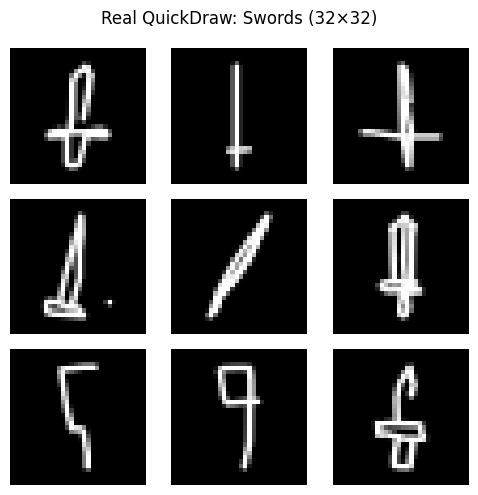

In [64]:

# visualizing the real swords
fig, axes = plt.subplots(3,3, figsize=(5,5))
for ax in axes.flatten():
    idx = np.random.randint(len(imgs_sword))
    ax.imshow(imgs_sword[idx,0]*0.5+0.5, cmap='gray')
    ax.axis('off')
plt.suptitle("Real QuickDraw images: Swords (32×32)")
plt.tight_layout()
plt.show()  # Showing the image

In [70]:
# Train DCGAN on Swords
# I used a lower learning rate for D to prevent it from overpowering G,
# and train for 30 epochs using our reusable train_dcgan function.

z_dim_s       = 100
lr_G_s       = 2e-4    # standard DCGAN lr for generator
lr_D_s       = 1e-5    # slower lr for discriminator to slow its convergence
epochs_sword= 30 # The number of epochs

# instantiate Generator and Discriminator for the “sword” category
# (assumes Generator_2 and Discriminator_2 are defined with 32×32 outputs/inputs)

G_s        = Generator_2(z_dim_s).to(device)
D_s        = Discriminator_2().to(device)
opt_G_s    = optim.Adam(G_s.parameters(), lr=lr_G_s, betas=(0.5,0.999))
opt_D_s    = optim.Adam(D_s.parameters(), lr=lr_D_s, betas=(0.5,0.999))
criterion_s  = nn.BCELoss() # binary cross-entropy loss for adversarial training

#losses_Gs, losses_Ds = [], []
fixed_noise_s = torch.randn(16, z_dim_s,1,1, device=device)



losses_Ds, losses_Gs = train_dcgan(
    G=G_s,
    D=D_s,
    dataloader=loader_sword,
    epochs=epochs_sword,
    z_dim=z_dim_s,
    device=device,
    opt_G=opt_G_s,
    opt_D=opt_D_s,
    criterion=criterion_s
)

Epoch 01/30  |  D loss: 0.9583  |  G loss: 0.4518
Epoch 02/30  |  D loss: 1.1231  |  G loss: 0.4207
Epoch 03/30  |  D loss: 0.7736  |  G loss: 0.7082
Epoch 04/30  |  D loss: 0.8178  |  G loss: 0.6511
Epoch 05/30  |  D loss: 0.6538  |  G loss: 0.8165
Epoch 06/30  |  D loss: 0.6502  |  G loss: 0.8352
Epoch 07/30  |  D loss: 0.5770  |  G loss: 0.8305
Epoch 08/30  |  D loss: 0.6903  |  G loss: 0.7481
Epoch 09/30  |  D loss: 0.5279  |  G loss: 0.9885
Epoch 10/30  |  D loss: 0.5758  |  G loss: 0.9007
Epoch 11/30  |  D loss: 0.7666  |  G loss: 0.6449
Epoch 12/30  |  D loss: 0.7152  |  G loss: 0.7082
Epoch 13/30  |  D loss: 0.7029  |  G loss: 0.7060
Epoch 14/30  |  D loss: 0.6957  |  G loss: 0.7096
Epoch 15/30  |  D loss: 0.6791  |  G loss: 0.7387
Epoch 16/30  |  D loss: 0.6944  |  G loss: 0.7266
Epoch 17/30  |  D loss: 0.6719  |  G loss: 0.7341
Epoch 18/30  |  D loss: 0.6737  |  G loss: 0.7463
Epoch 19/30  |  D loss: 0.6942  |  G loss: 0.7237
Epoch 20/30  |  D loss: 0.6348  |  G loss: 0.8054


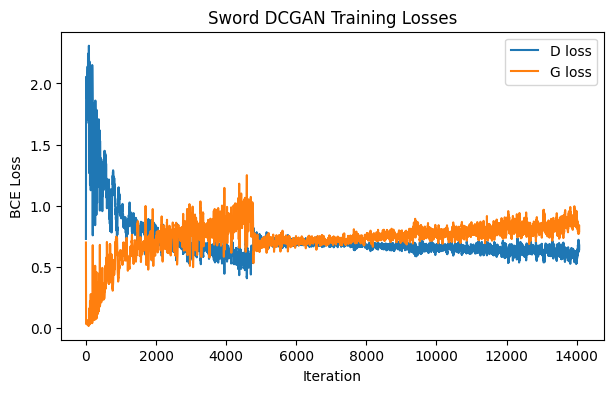

In [71]:
#Results: Loss Curves
plt.figure(figsize=(7,4))
plt.plot(losses_Ds, label='D loss')
plt.plot(losses_Gs, label='G loss')
plt.xlabel('Iteration'); plt.ylabel('BCE Loss')
plt.legend(); plt.title('Sword DCGAN Training Losses')
plt.show()

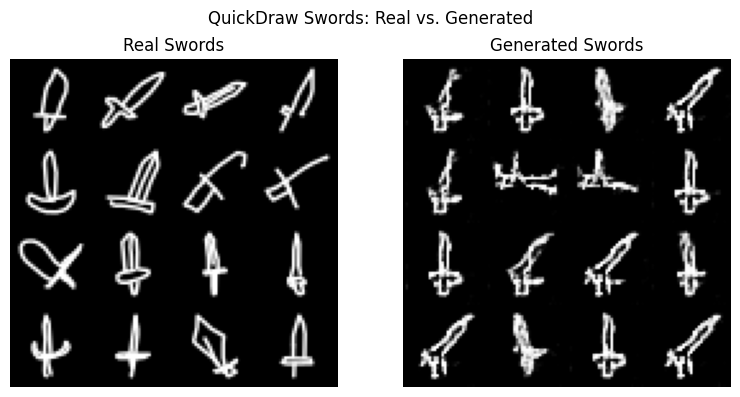

In [72]:

# Final Comparison: Real vs. Generated Swords
idxs_s = np.random.choice(len(imgs_sword), 16, replace=False)
real16_s = imgs_sword[idxs_s].reshape(16,32,32)

# ---------------------------------------------------------
# Generate 16 genereated sword sketches using the trained generator
# ---------------------------------------------------------

with torch.no_grad():
    noise_s = torch.randn(16, z_dim,1,1,device=device)
    generated16_s= G_s(noise_s).cpu().numpy().reshape(16,32,32) * 0.5 + 0.5

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(np.block([[real16_s[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[0].set_title("Real Swords"); axes[0].axis('off')
axes[1].imshow(np.block([[generated16_s[i*4+j] for j in range(4)] for i in range(4)]), cmap='gray')
axes[1].set_title("Generated Swords"); axes[1].axis('off')

# Overall figure title and layout adjustments
plt.suptitle("QuickDraw Swords: Real vs. Generated")
plt.tight_layout()
plt.show()

## Insights
1. Silhouette & Structure
Blades, guards, and handles are now clearly delineated. The model reliably produces vertical and slightly tilted swords, and even captures a few curved‐blade styles.

2. Edge Fidelity
Some blurriness remains along the blade edges and guard details, but overall stroke continuity is much improved over the initial run.

3. Mode Coverage
We see multiple hilt shapes and orientations—no longer a single “average sword.” However, very ornate or highly stylized variants (rare in the dataset) still don’t appear, indicating mild mode‐collapse on the tail of the distribution.



# ON WHICH DATASET, THE MODEL WORKS BETTER ON?
The DCGAN clearly performs best on the Smiley Faces dataset and on Swords you get good coarse structure but mild mode collapse on rare styles, and on Cats the model struggles with fine details and pose diversity, collapsing to a generic “head‐only” mode. So for low‐complexity sketches, the DCGAN is most effective, smiley faces are the “sweet spot” for this baseline architecture.
